![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR25h4pKb39YYlqtsFr_mVoUMiE91pPKgsZNSbksgLi7mf2nPNI&usqp=CAU)

# Introduction 

## Problem Statement
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

## Specific Objectives

Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to 1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 2) Accurately distinguish between many diseases, sometimes more than one on a single leaf; 3) Deal with rare classes and novel symptoms; 4) Address depth perception—angle, light, shade, physiological age of the leaf; and 5) Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.


# Data 

## Data Description
Given a photo of an apple leaf, can you accurately assess its health? This competition will challenge you to distinguish between leaves which are healthy, those which are infected with apple rust, those that have apple scab, and those with more than one disease.

## Files

### train.csv
image_id: the foreign key for the parquet files
combinations: one of the target labels
healthy: one of the target labels
rust: one of the target labels
scab: one of the target labels
images
A folder containing the train and test images, in jpg format.

### test.csv
image_id: the foreign key for the parquet files

### sample_submission.csv
image_id: the foreign key for the parquet files
combinations: one of the target labels
healthy: one of the target labels
rust: one of the target labels
scab: one of the target labels

## Image of leaves

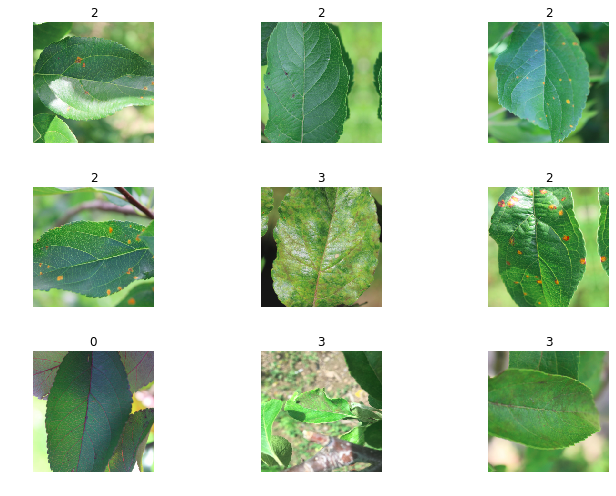

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing required fastai modules and packages

package fastai.vision provides infinite number of functionalities to deal with computer vision problems like image classification, image segmentation etc...

In [ ]:
import torch
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
torch.cuda.set_device(0)

In [ ]:
torch.cuda.get_device_name()

In [ ]:
traindf = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
traindf.head()

In [ ]:
traindf.shape

We can see that image id is like "Train_1", "Train_2" etc. Now using shape attribute in above code shell, it is clear that in training folder we are having **1821** images. **Is this the case of multi class classification ?**.

In [ ]:
classdata = (traindf.healthy + traindf.multiple_diseases+
             traindf.rust + traindf.scab)

In [ ]:
classdata.head()

In [ ]:
any(classdata > 1)

In classdata we can see that, no value is greater than 1. Hence it is not multiclass classification problem.  We are going to take the following as class. Fastai can read image file path and its associated class from a Pandas DataFrame too. 
                              We are having file name and its class in a dataframe **traindf**. But we need the data is following format 
                              
|     name     | label |
|:------------:|-------|
| Train_0.jpg  | 3     |
| Train_1.jpg  | 1     |
| Train_2.jpg  | 0     |

In [ ]:
#pathstr = "/kaggle/input/plant-pathology-2020-fgvc7/images/"
traindf["image_id"] =traindf["image_id"].astype("str") + ".jpg"
traindf.head()

Let us define classes as follows 

|                            name                             | class |
|:------------------:|-------|
| healthy            | 0     |
| multiple_diseases  | 1     |
| rust               | 2     |
| scab               | 3     |

In [ ]:
traindf["label"] = (0*traindf.healthy + 1*traindf.multiple_diseases+
             2*traindf.rust + 3*traindf.scab)
traindf.drop(columns=["healthy","multiple_diseases","rust","scab"],inplace=True)

In [ ]:
traindf.head()

# Reading the image files

Reading image file required for following

- An transformation object
- We have to create an ImageDataBunch object

In [ ]:
# Creation of transformation object
transformations = get_transforms(do_flip = True,
                                 flip_vert=True, 
                                 max_lighting=0.1, 
                                 max_zoom=1.05,
                                 max_warp=0.,
                                 max_rotate=15,
                                 p_affine=0.75,
                                 p_lighting=0.75
                                )

### Explanation on arguments of  get_transforms() function

- do_flip: if True, a random flip is applied with probability 0.5
- flip_vert: requires do_flip=True. If True, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied
- max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
- max_zoom: if not 1. or less, a random zoom between 1. and max_zoom is applied with probability p_affine
- max_lighting: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
- max_warp: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
- p_affine: the probability that each affine transform and symmetric warp is applied
- p_lighting: the probability that each lighting transform is applied
- xtra_tfms: a list of additional transforms you would like to be applied

# Creation of ImageDataBunch object 

Image analysis specific DataBunch in fastai is ImageDataBunch. There are infinite number of factory methods to create it. Structure of the data is like all images are in  a directory **"/kaggle/input/plant-pathology-2020-fgvc7/images"**. In order to create more mess training and testing data are at same place. The class of images for training porpose has been given in a file **"/kaggle/input/plant-pathology-2020-fgvc7/train.csv"**. 

In [ ]:
pathofdata = "/kaggle/input/plant-pathology-2020-fgvc7/"

In [ ]:
data  = ImageDataBunch.from_df(path=pathofdata, 
                               df=traindf, 
                               folder="images",
                               label_delim=None,
                               valid_pct=0.2,
                               seed=100,
                               fn_col=0, 
                               label_col=1, 
                               suffix='',
                               ds_tfms=transformations, 
                               size=512,
                               bs=64, 
                               val_bs=32,
                               )

In [ ]:
data.show_batch(rows=3, figsize=(10,7))

In [ ]:
data = data.normalize()

In [ ]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True
                      ,metrics=[error_rate, accuracy]).to_fp16()

# Finding the learning rate 

Fastai provide functionality to find optimized learning rate. In order to find the optimized learning rate, the method **lr_find()** can be used. The method plot() defined on recorder can be used to plot a line plot between Loss vs. learning Rate. Fastai provide the suggestion also for optimize learning rate.

In [ ]:
learner.model_dir = '/kaggle/working/models'

In [ ]:
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [ ]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

### 1cycle policy
The knowleledge in this cell about one cycle plicy, is taken from kernel https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai.


1cycle policy
We will use the one cycle policy proposed by Leslie Smith, arXiv, April 2018. The policy brings more disciplined approach for selecting hyperparameters such as learning rate and weight decay. This can potentially save us a lot of time from training with suboptimal hyperparameters. In addititon, Fastai library has implemented a training function for one cycle policy that we can use with only a few lines of code.

Sylvian Gugger wrote a very clear explanation of Leslie's proposal that I recommend for reading.

First, we find the optimal learning rate and weight decay values. The optimal lr is just before the base of the loss and before the start of divergence. It is important that the loss is still descending where we select the learning rate.

As for the weight decay that is the L2 penalty of the optimizer, Leslie proposes to select the largest one that will still let us train at a high learning rate so we do a small grid search with 1e-2, 1e-4 and 1e-6 weight decays.

### You can read more about this approach in following research paper

https://arxiv.org/pdf/1803.09820.pdf


# Training the leraner 

We are going to train our learner using fit one cycle method. Learner is trained by 10 cycle. We have allready got the optimized learning rate suggestion from fastai. 

In [ ]:
lr = mingradlr
learner.fit_one_cycle(10, lr)


In [ ]:
learner.unfreeze()
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [ ]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

# Differential learning 

Differential learning is also a very important concept. According to this concept, different learning rate is applied at different layer of deep neural network. In following line of code we are applying differential learning rate.

In [ ]:
# Differential learning 
learner.fit_one_cycle(7, slice(mingradlr1, mingradlr1/20))

In [ ]:
learner.show_results()

## A discussion on output of show_results() method.

The method showing classification results on 25 images. Out of 25 images 3 images has been predicted wrongly. But if you will look at wrongly classified image, the first image has been found in 2nd row from top and fifth column. This image is having more than one leaf. Let us concentrate on the second wrongly classified image. This image can be found in third row from top and in fifth column. And this image is also having many leaves. And same is the case with the third wrongly classified image.

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

## A discussion on output of confusion matrix.

We have denoted multiple_diseases as 1. And resnet34 is not very good in classifying, if image leaf is having multiple_diseases. 

In [ ]:
testdf = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
testdf.head()

In [ ]:
sampsubmit = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv")
sampsubmit.head()

In [ ]:
pathofdata = "/kaggle/input/plant-pathology-2020-fgvc7/"

# Reading test data

We have to read the data that we are going to perform using reading first all the paths of images and then we will filter out path of only  Test data files.

In [ ]:
testdata= ImageList.from_folder(pathofdata+"images")

Filtering the path of Test image data files.

In [ ]:
testdata.filter_by_func(lambda x: x.name.startswith("Test"))

You might not believing on me that, we have till got the path of Test image files. No problem let it print. 

In [ ]:
testdata.items[0]

# Reading two image data

Fastai provides function open_image() which read and return one image tensor at a time. Following line of code is reading two images.

In [ ]:
img1 = open_image(testdata.items[0])
img2 = open_image(testdata.items[1])

## Prediction the data

predict() method can be used to predict class of image. Following line of code is predicting and printing the output. Its come as tuple. The second element in tuple is a class tensor and last element is probability tensor to become in different class.

In [ ]:
learner.predict(img1)

Second element of result 

In [ ]:
val1 = learner.predict(img1)[2].tolist()
val2 = learner.predict(img2)[2].tolist()

How output looks like ?

In [ ]:
val1

In [ ]:
tdtd = testdata.items[0]

In [ ]:
tdtd.name[:-4:]

In [ ]:
resultlist = []
for item in testdata.items:
    img = open_image(item)
    predval = learner.predict(img)[2].tolist()
    predval.insert(0,item.name[:-4:])
    resultlist.append(predval)

## Result list 

In [ ]:
resultlist[0:5]

### Transform result data into a dataframe

In [ ]:
resultdf = pd.DataFrame(resultlist)
resultdf.columns = sampsubmit.columns
resultdf.head()

In [ ]:
resultdf.set_index("image_id",inplace=True)
resultdf.head()

In [ ]:
resultdf = resultdf.loc[sampsubmit.image_id,:]
resultdf.head()

In [ ]:
resultdf.reset_index(inplace=True)

In [ ]:
resultdf.head()

## Submit the result

In [ ]:
resultdf.to_csv("submit.csv",index=False)